# Build BOW Model

In [39]:
from keras.datasets import imdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras import regularizers

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import nltk
import numpy as np
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

import unicodedata
import re
import re
import string
import html

from sklearn.model_selection import train_test_split

stop_words = set(stopwords.words('english'))
#print(stop_words)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load movie dataset

In [2]:
from pathlib import Path
import os
DATA_PATH=Path('./dat/')
DATA_PATH.mkdir(exist_ok=True)
if not os.path.exists('./dat/aclImdb'):
    !curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    !tar -xf aclImdb_v1.tar.gz -C {DATA_PATH}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  16.3M      0  0:00:04  0:00:04 --:--:-- 16.3M


Let's have a look on the raw data:

In [3]:
classes = ['pos', 'neg']
path =Path('./dat/aclImdb/')

def get_texts(path):
    texts ,labels =[],[]
    for idx,label in enumerate(classes):
        data_path = os.path.join(path,label)
        for fname in (path/label).glob('*.txt'):
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)

    return texts,labels


trn_texts,trn_labels = get_texts(path/'train')
tst_texts,tst_labels = get_texts(path/'test')




In [4]:
trn_texts[0]

"The Night Listener held my attention, with Robin Williams shining as a New York City radio host who becomes enamored with his friendship with a 14 year old boy (Rory Culkin) who is very ill. Williams has never met the boy in person, as they have only been in contact by talking on the telephone. However, Williams' ex-boyfriend (nice job from Bobby Cannavale) raises doubt about the boy, which prompts Williams to arrange a meeting with him in person. What follows makes a permanent impact on Williams in a way he does not expect. I will leave it at that. Toni Collette also stars.<br /><br />I enjoyed this film, with Toni Collette giving a memorable portrayal of Culkin's adoptive mother. Sandra Oh also starred as Williams' friend. The Night Listener is inspired by actual events, and it has a somber, almost creepy silence throughout. At times it is predictable, no thanks to some of the reviews I read before seeing the movie and just due to logic, but I liked it anyway. I enjoy Williams in ro

In [5]:
np.unique(trn_labels)

array([0, 1])

### Text_Preprocessing

In [6]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)


def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]

In [7]:
trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

### Text preparation

In [8]:
vocab_sz = 10000
# split text into tokens and build vocav
tok = Tokenizer(num_words=vocab_sz,oov_token='UNK')
tok.fit_on_texts(trn_texts+tst_texts)

tok.word_index


{'UNK': 1,
 'movie': 2,
 'film': 3,
 'one': 4,
 'make': 5,
 'like': 6,
 'see': 7,
 'get': 8,
 'time': 9,
 'good': 10,
 'character': 11,
 'watch': 12,
 'go': 13,
 'even': 14,
 'story': 15,
 'think': 16,
 'would': 17,
 'really': 18,
 'show': 19,
 'scene': 20,
 'well': 21,
 'look': 22,
 'say': 23,
 'much': 24,
 'know': 25,
 'end': 26,
 'people': 27,
 'great': 28,
 'bad': 29,
 'also': 30,
 'give': 31,
 'first': 32,
 'take': 33,
 'act': 34,
 'play': 35,
 'love': 36,
 'way': 37,
 'dont': 38,
 'come': 39,
 'thing': 40,
 'find': 41,
 'could': 42,
 'life': 43,
 'seem': 44,
 'work': 45,
 'many': 46,
 'plot': 47,
 'actor': 48,
 'want': 49,
 'two': 50,
 'never': 51,
 'year': 52,
 'try': 53,
 'best': 54,
 'little': 55,
 'ever': 56,
 'better': 57,
 'man': 58,
 'still': 59,
 'feel': 60,
 'part': 61,
 'something': 62,
 'lot': 63,
 'back': 64,
 'interest': 65,
 'im': 66,
 'director': 67,
 'real': 68,
 'guy': 69,
 'performance': 70,
 'doesnt': 71,
 'use': 72,
 'didnt': 73,
 'woman': 74,
 'though': 75,
 

### Extract binary BoW features

In [9]:
x_train = tok.texts_to_matrix(trn_texts,mode='binary')
x_test = tok.texts_to_matrix(tst_texts,mode='binary')


y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(25000, 10000)
(25000,)
(25000, 10000)
(25000,)


In [10]:
# Split train data into train and validation
x_train,x_val ,y_train,y_val = train_test_split(x_train,y_train,test_size=0.4,random_state=42)

In [11]:
model_1 = Sequential()
model_1.add(Dense(16,activation='relu',input_shape=(vocab_sz,)))
model_1.add(Dense(16,activation='relu'))
model_1.add(Dense(1,activation='sigmoid'))

model_1.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[metrics.binary_accuracy])

history = model_1.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - binary_accuracy: 0.7309 - loss: 0.6074 - val_binary_accuracy: 0.8560 - val_loss: 0.4250
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - binary_accuracy: 0.8930 - loss: 0.3713 - val_binary_accuracy: 0.8722 - val_loss: 0.3394
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - binary_accuracy: 0.9114 - loss: 0.2748 - val_binary_accuracy: 0.8766 - val_loss: 0.3078
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - binary_accuracy: 0.9255 - loss: 0.2205 - val_binary_accuracy: 0.8770 - val_loss: 0.2988
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - binary_accuracy: 0.9420 - loss: 0.1823 - val_binary_accuracy: 0.8760 - val_loss: 0.3056
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - binary_accuracy: 0.9519 - loss: 0.1551 - val_binary_accuracy: 0.8757 - val_loss: 0.3152
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - binary_accuracy: 0.9609 - loss: 0.1338 - val_binary_accuracy: 0.8740 - val_loss: 0.3278
Epoch 8/20
30

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

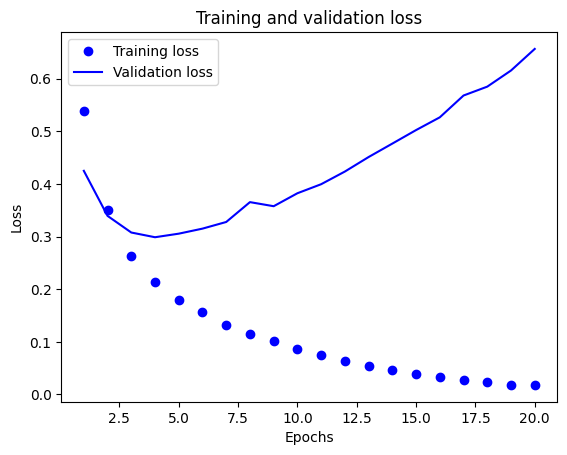

In [12]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epocs=range(1,len(acc)+1)

plt.plot(epocs,loss,'bo',label='Training loss')
plt.plot(epocs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

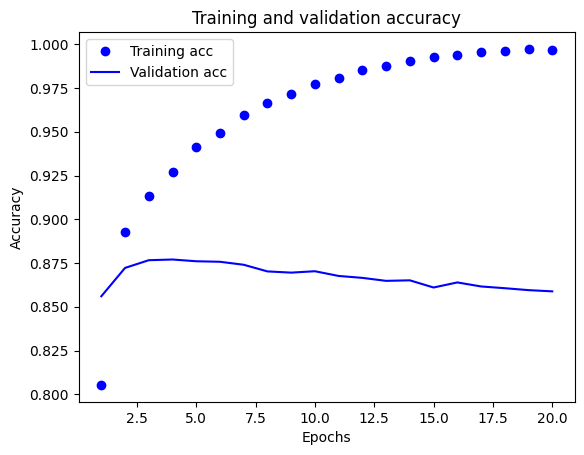

In [13]:
epocs = range(1,len(acc)+1)
plt.plot(epocs,acc,'bo',label='Training acc')
plt.plot(epocs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Count

In [14]:
x_train = tok.texts_to_matrix(trn_texts,mode='count')
x_test = tok.texts_to_matrix(tst_texts,mode='count')


y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# Split train data into train and validation
x_train,x_val ,y_train,y_val = train_test_split(x_train,y_train,test_size=0.4,random_state=42)

# build model
model_2 = Sequential()
model_2.add(Dense(16,activation='relu',input_shape=(vocab_sz,)))
model_2.add(Dense(16,activation='relu'))
model_2.add(Dense(1,activation='sigmoid'))

model_2.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[metrics.binary_accuracy])

history_2 = model_2.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict_2 = history_2.history
history_dict_2.keys()



(25000, 10000)
(25000,)
(25000, 10000)
(25000,)
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - binary_accuracy: 0.7099 - loss: 0.6029 - val_binary_accuracy: 0.8606 - val_loss: 0.4107
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - binary_accuracy: 0.8918 - loss: 0.3538 - val_binary_accuracy: 0.8676 - val_loss: 0.3466
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - binary_accuracy: 0.9136 - loss: 0.2607 - val_binary_accuracy: 0.8800 - val_loss: 0.3039
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - binary_accuracy: 0.9333 - loss: 0.2050 - val_binary_accuracy: 0.8827 - val_loss: 0.3098
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - binary_accuracy: 0.9460 - loss: 0.1694 - val_binary_accuracy: 0.8564 - val_loss: 0.3699
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - binary_accuracy: 0.9509 - loss: 0.1523 - val_binary_accuracy: 0.8768 - val_loss: 0.3357
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - binary_accuracy: 0.9608 - loss: 0.1291 - val_binary_a

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

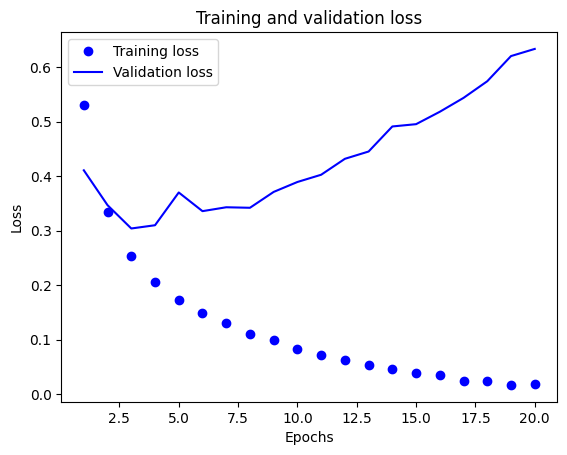

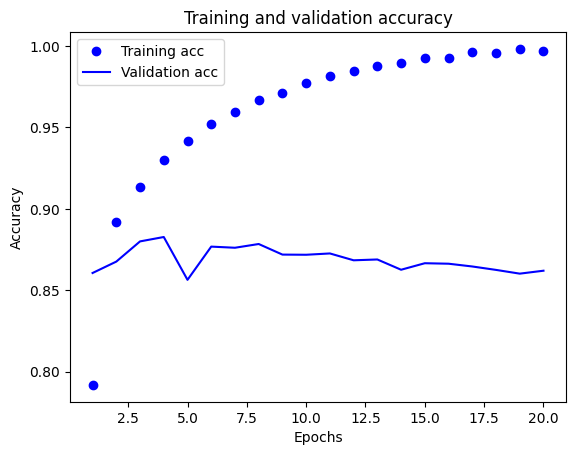

In [15]:
acc = history_dict_2['binary_accuracy']
val_acc = history_dict_2['val_binary_accuracy']
loss = history_dict_2['loss']
val_loss = history_dict_2['val_loss']

epocs=range(1,len(acc)+1)

plt.plot(epocs,loss,'bo',label='Training loss')
plt.plot(epocs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

epocs = range(1,len(acc)+1)
plt.plot(epocs,acc,'bo',label='Training acc')
plt.plot(epocs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




### Freq

In [16]:
x_train = tok.texts_to_matrix(trn_texts,mode='freq')
x_test = tok.texts_to_matrix(tst_texts,mode='freq')


y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# Split train data into train and validation
x_train,x_val ,y_train,y_val = train_test_split(x_train,y_train,test_size=0.4,random_state=42)

# build model
model_3 = Sequential()
model_3.add(Dense(16,activation='relu',input_shape=(vocab_sz,)))
model_3.add(Dense(16,activation='relu'))
model_3.add(Dense(1,activation='sigmoid'))

model_3.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[metrics.binary_accuracy])

history_3 = model_3.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict_3 = history_3.history
history_dict_3.keys()



(25000, 10000)
(25000,)
(25000, 10000)
(25000,)
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - binary_accuracy: 0.5077 - loss: 0.6930 - val_binary_accuracy: 0.4962 - val_loss: 0.6928
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - binary_accuracy: 0.5603 - loss: 0.6923 - val_binary_accuracy: 0.5540 - val_loss: 0.6915
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - binary_accuracy: 0.6073 - loss: 0.6911 - val_binary_accuracy: 0.5836 - val_loss: 0.6900
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - binary_accuracy: 0.6446 - loss: 0.6892 - val_binary_accuracy: 0.6371 - val_loss: 0.6873
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - binary_accuracy: 0.6760 - loss: 0.6863 - val_binary_accuracy: 0.6714 - val_loss: 0.6834
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - binary_accuracy: 0.6927 - loss: 0.6821 - val_binary_accuracy: 0.6675 - val_loss: 0.6783
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - binary_accuracy: 0.6984 - loss: 0.6759 - val_binary_a

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

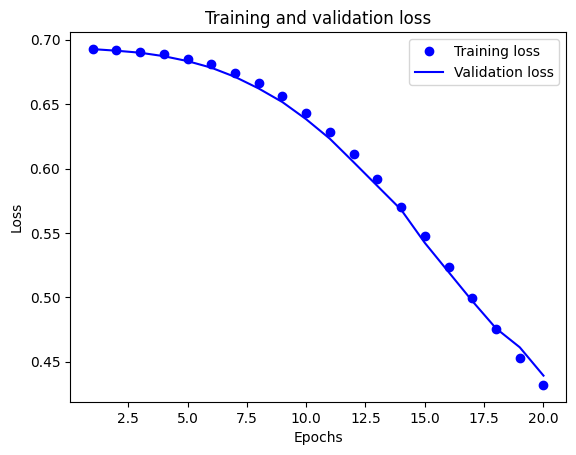

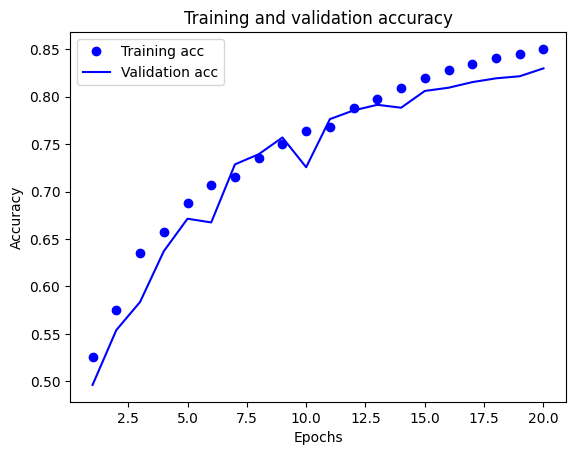

In [17]:
acc = history_dict_3['binary_accuracy']
val_acc = history_dict_3['val_binary_accuracy']
loss = history_dict_3['loss']
val_loss = history_dict_3['val_loss']

epocs=range(1,len(acc)+1)

plt.plot(epocs,loss,'bo',label='Training loss')
plt.plot(epocs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
print()

epocs = range(1,len(acc)+1)
plt.plot(epocs,acc,'bo',label='Training acc')
plt.plot(epocs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




In [18]:
y_pred = model_3.predict(x_test)

# measure accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred.round())


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


0.83652

###  TfIdF

In [19]:
# bulid vocb using tfidfVictorizer
vectorizer = TfidfVectorizer(max_features=vocab_sz)
vectorizer.fit(trn_texts+tst_texts)

x_train = vectorizer.transform(trn_texts)
x_test = vectorizer.transform(tst_texts)


y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# Split train data into train and validation
x_train,x_val ,y_train,y_val = train_test_split(x_train,y_train,test_size=0.4,random_state=42)

# build model
model_4 = Sequential()
model_4.add(Dense(16,activation='relu',input_shape=(vocab_sz,)))
model_4.add(Dense(16,activation='relu'))
model_4.add(Dense(1,activation='sigmoid'))

model_4.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[metrics.binary_accuracy])

history_4 = model_4.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict_4 = history_4.history
history_dict_4.keys()



(25000, 10000)
(25000,)
(25000, 10000)
(25000,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - binary_accuracy: 0.6178 - loss: 0.6900 - val_binary_accuracy: 0.8059 - val_loss: 0.6706
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - binary_accuracy: 0.8436 - loss: 0.6570 - val_binary_accuracy: 0.8381 - val_loss: 0.6180
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - binary_accuracy: 0.8662 - loss: 0.5952 - val_binary_accuracy: 0.8464 - val_loss: 0.5484
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - binary_accuracy: 0.8733 - loss: 0.5178 - val_binary_accuracy: 0.8586 - val_loss: 0.4747
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - binary_accuracy: 0.8844 - loss: 0.4377 - val_binary_accuracy: 0.8625 - val_loss: 0.4106
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - binary_accuracy: 0.8930 - loss: 0.3693 - val_binary_accuracy: 0.8695 - val_loss: 0.3613
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - binary_accuracy: 0.9063 - loss: 0.3108 - val_binary_accuracy: 0.8753 - val_loss: 0.3267
Epoch 8/20
30

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

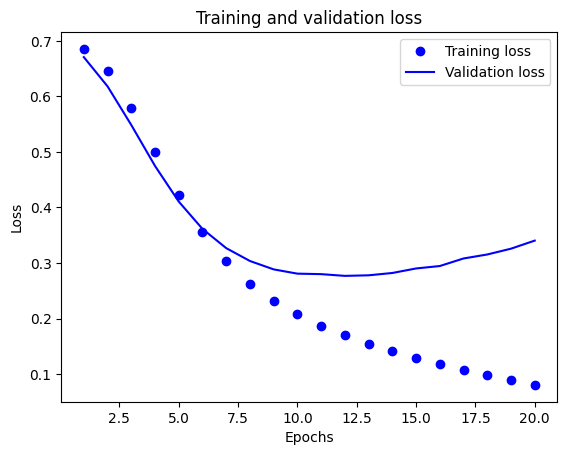

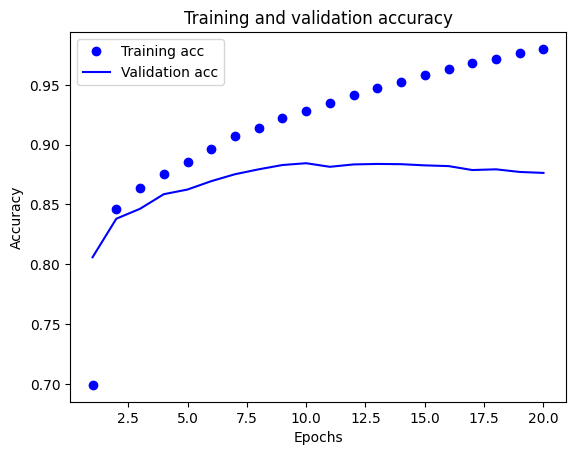

In [20]:
acc = history_dict_4['binary_accuracy']
val_acc = history_dict_4['val_binary_accuracy']
loss = history_dict_4['loss']
val_loss = history_dict_4['val_loss']

epocs=range(1,len(acc)+1)

plt.plot(epocs,loss,'bo',label='Training loss')
plt.plot(epocs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
print()

epocs = range(1,len(acc)+1)
plt.plot(epocs,acc,'bo',label='Training acc')
plt.plot(epocs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




In [21]:
model_4.evaluate(x_test,y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8362 - loss: 0.4461


[0.3830925524234772, 0.8576800227165222]

# Bag-of-word Vectors:

# Word Embedding
A word embedding is a class of approaches for representing words and documents using a
dense vector representation. It is an improvement over more the traditional bag-of-word model
encoding schemes where large sparse vectors were used to represent each word or to score each
word within a vector to represent an entire vocabulary. These representations were sparse
because the vocabularies were vast and a given word or document would be represented by a
large vector comprised mostly of zero values.
Instead, in an embedding, words are represented by dense vectors where a vector represents
the projection of the word into a continuous vector space. The position of a word within the
vector space is learned from text and is based on the words that surround the word when it is
used. The position of a word in the learned vector space is referred to as its embedding. Two
popular examples of methods of learning word embeddings from text include:

- Word2Vec.
- GloVe.
In addition to these carefully designed methods, a word embedding can be learned as part
of a deep learning model. This can be a slower approach, but tailors the model to a speci
c
training dataset.

### First: Word2Vec : Bage Of Word Vector Model
Note:
- Embedding layer can only be indexed with word index

__What do we do?__

We need to feed actual word indices. In other words, we need to convert word into sequence features.

In [34]:
vocab_sz=10000
tok =Tokenizer(num_words=vocab_sz,oov_token='UNK')
tok.fit_on_texts(trn_texts+tst_texts)

x_train = tok.texts_to_sequences(trn_texts)
x_test = tok.texts_to_sequences(tst_texts)

max_len = 100
x_train = pad_sequences(x_train,maxlen=max_len)
x_test = pad_sequences(x_test,maxlen=max_len)

y_train=np.asarray(trn_labels).astype('float32')
y_test=np.asarray(tst_labels).astype('float32')

# split x_train , y_train into train,val
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.4,random_state=42)

print(x_train[0])
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)


[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    1 1167    9  471  180   36   15
   71   45 3344   77 7732 5800 1869 7732 5800  395  356    3  641   22
  220  189   82  490    1   14    7  113    1    9   76  491 1300   20
  417   20  126  147   99  570   12    1   20  737  803  281 1298  595
  230   24]
(15000, 100)
(15000,)
(10000, 100)
(10000,)


In [35]:
x_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,   18,   36,  183,  173,  297,  103,  841,    1, 2068,
        360,  119,  373,  210,  320,  360,   45,   14,   75,  921,    1,
          1,   96,  360,  133,    3,    1,    1,  189,  210, 1202,    5,
        822,    4,    5,    1,  196,  471,  236, 1426,    1,  335,    1,
         75,   11,  887, 3638,   13,  841,  805,    1, 1925,    1,    4,
        840], dtype=int32)

** Build Model **

In [41]:
n_latent_factors = 25
vocab_sz = 10000

model_v =Sequential()
model_v.add(Embedding(input_dim=vocab_sz+1,output_dim=n_latent_factors,input_length=max_len,embeddings_regularizer=regularizers.L2(0.01)))
model_v.add(Flatten())
model_v.add(Dense(16,activation='relu'))
model_v.add(Dense(16,activation='relu'))
model_v.add(Dense(1,activation='sigmoid'))


model_v.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[metrics.binary_accuracy])

history_v = model_v.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

model_v.summary()

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - binary_accuracy: 0.5001 - loss: 1.9833 - val_binary_accuracy: 0.4984 - val_loss: 0.9140
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - binary_accuracy: 0.5228 - loss: 0.8258 - val_binary_accuracy: 0.5683 - val_loss: 0.6941
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - binary_accuracy: 0.6441 - loss: 0.6720 - val_binary_accuracy: 0.7787 - val_loss: 0.6160
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - binary_accuracy: 0.7849 - loss: 0.5876 - val_binary_accuracy: 0.8199 - val_loss: 0.5507
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 0.8431 - loss: 0.5225 - val_binary_accuracy: 0.7751 - val_loss: 0.5331
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 0.8573 - loss: 0.4660 - val_binary_accuracy: 0.8196 - val_loss: 0.4792
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - binary_accuracy: 0.8735 - loss: 0.4158 - val_binary_accuracy: 0.8578 - val_loss: 0.4273
Epoch 8/20
30/30 ━━━━━━━

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 100, 25)             │         250,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 16)                  │          40,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 580,662 (2.22 MB)

 Trainable params: 290,330 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 290,332 (1.11 MB)

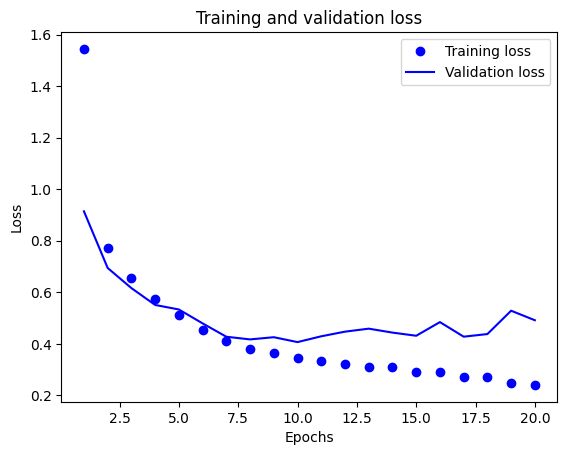

In [42]:
acc = history_v.history['binary_accuracy']
val_acc = history_v.history['val_binary_accuracy']
loss = history_v.history['loss']
val_loss = history_v.history['val_loss']

epocs=range(1,len(acc)+1)

plt.plot(epocs,loss,'bo',label='Training loss')
plt.plot(epocs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()




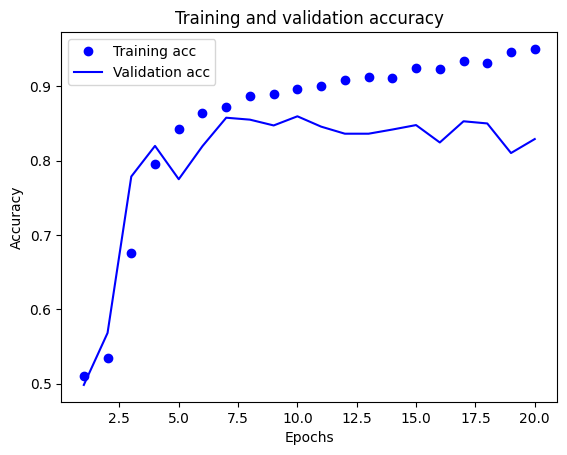

In [43]:
plt.plot(epocs,acc,'bo',label='Training acc')
plt.plot(epocs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#

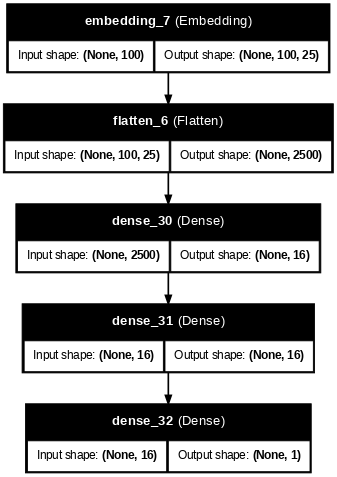

In [50]:
plot_model(model_v, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

# Pre-trained word Embeddings

In the above setting, we used a _learnable_ `Embedding` layer, which updates its ___randomly___ initialized weights, from the task at hand.

Another approach would be to load some pre-trained word vectors, that are trained on some other useful task in NLP, and then use those pre-trained vectors to initialize our Embedding table vectors.

One of the popular pre-trained embeddings is _GloVe_

# Loading GloVe

The Keras Embedding layer can also use a word embedding learned elsewhere. It is common in the NLP to learn, save, and make freely available word
embeddings. For example, the researchers behind GloVe method provide a suite of pre-trained word embeddings on their website released under a public domain license.

__Load embeddings for your vocab__

We need to create a matrix of one embedding for each word in the training
dataset. We can do that by enumerating all unique words in the Tokenizer.word index and
locating the embedding weight vector from the loaded GloVe embedding. The result is a matrix
of weights only for words we will see during training.

```
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
```

Now we can dene our model, t, and evaluate it as before. The key dierence is that
the Embedding layer can be seeded with the GloVe word embedding weights. We chose the
100-dimensional version, therefore the Embedding layer must be dened with output dim set to
100. Finally, we do not want to update the learned word weights in this model, therefore we
will set the trainable attribute for the model to be False.

```
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)
```

In [51]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-11-26 17:12:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-26 17:12:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-26 17:12:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [52]:
vocab_sz=10000

tok =Tokenizer(num_words=vocab_sz,oov_token='UNK')
tok.fit_on_texts(trn_texts+tst_texts)

x_train = tok.texts_to_sequences(trn_texts)
x_test = tok.texts_to_sequences(tst_texts)

max_len = 100
x_train = pad_sequences(x_train,maxlen=max_len)
x_test = pad_sequences(x_test,maxlen=max_len)

y_train=np.asarray(trn_labels).astype('float32')
y_test=np.asarray(tst_labels).astype('float32')

# split x_train , y_train into train,val
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.4,random_state=42)




In [53]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt', mode='rt', encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [57]:
# create a weight matrix for words in training docs
vocab_size =len(tok.word_index)+1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tok.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [62]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len,trainable=False))  # no train on embedding paramaters
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# fit the model
history = model.fit(x_train,y_train,epochs=20,validation_data=(x_val,y_val))

# summarize the model
model.summary()

# evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)

print('Accuracy: %f' % (accuracy*100))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.6530 - loss: 0.6198 - val_acc: 0.7418 - val_loss: 0.5210
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - acc: 0.8155 - loss: 0.4097 - val_acc: 0.7417 - val_loss: 0.5438
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.8585 - loss: 0.3216 - val_acc: 0.7243 - val_loss: 0.5989
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - acc: 0.9087 - loss: 0.2342 - val_acc: 0.7234 - val_loss: 0.6508
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.9447 - loss: 0.1594 - val_acc: 0.7168 - val_loss: 0.8557
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.9760 - loss: 0.0895 - val_acc: 0.7014 - val_loss: 1.0197
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.9829 - loss: 0.0579 - val_acc: 0.7001 - val_loss: 1.2251
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - acc: 0.9912 - loss: 0.0344 - val_acc: 0.7039 - val_loss: 1.3581
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - 

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 100, 100)            │      14,107,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 16)                  │         160,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,587,917 (55.65 MB)

 Trainable params: 160,305 (626.19 KB)

 Non-trainable params: 14,107,000 (53.81 MB)

 Optimizer params: 320,612 (1.22 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7031 - loss: 2.2984
Accuracy: 71.395999


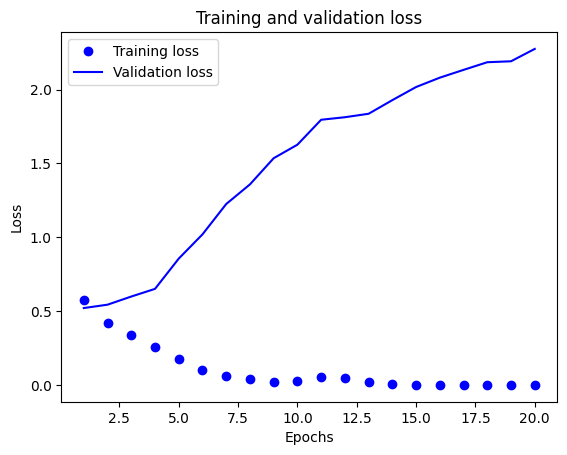

In [65]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

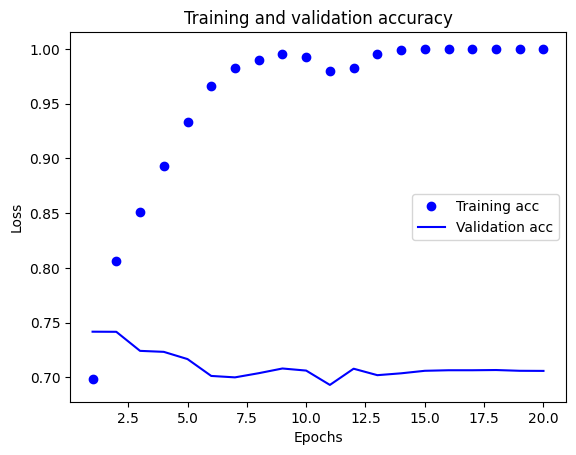

In [67]:
plt.clf()   # clear figure
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

__ train embedding parameters __

In [69]:
# define model
model_g = Sequential()
model_g.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len,trainable=True))  #  train embedding paramaters
model_g.add(Flatten())
model_g.add(Dense(16, activation='relu'))
model_g.add(Dense(16, activation='relu'))
model_g.add(Dense(1, activation='sigmoid'))

# compile the model
model_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# fit the model
histroy= model_g.fit(x_train,y_train,epochs=20,validation_data=(x_val,y_val))

# summarize the model
model_g.summary()

# evaluate the model
loss, accuracy = model_g.evaluate(x_test, y_test)

print('Accuracy: %f' % (accuracy*100))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 122s 245ms/step - acc: 0.6703 - loss: 0.5862 - val_acc: 0.8063 - val_loss: 0.4173
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 242ms/step - acc: 0.9099 - loss: 0.2369 - val_acc: 0.8182 - val_loss: 0.4363
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 243ms/step - acc: 0.9793 - loss: 0.0707 - val_acc: 0.8156 - val_loss: 0.5793
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 246ms/step - acc: 0.9965 - loss: 0.0167 - val_acc: 0.8190 - val_loss: 0.7673
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 245ms/step - acc: 0.9997 - loss: 0.0033 - val_acc: 0.8175 - val_loss: 0.8870
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 246ms/step - acc: 0.9998 - loss: 9.6295e-04 - val_acc: 0.8201 - val_loss: 0.9482
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 248ms/step - acc: 1.0000 - loss: 3.0052e-04 - val_acc: 0.8200 - val_loss: 0.9982
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 246ms/step - acc: 1.0000 - loss: 1.8603e-04 - val_acc: 0.8198 - val_loss: 1.0347
Epoch 9/20
4

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ (None, 100, 100)            │      14,107,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 16)                  │         160,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,801,917 (163.28 MB)

 Trainable params: 14,267,305 (54.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,534,612 (108.85 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8231 - loss: 1.4172
Accuracy: 82.103997
